# Predict Hike/Keep/Lower from FOMC documents
## Prep work
### Install/Import necessary libraries

In [1]:
!pip install transformers
!pip install torch

Looking in links: https://files.pythonhosted.org/
Looking in links: https://files.pythonhosted.org/


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

from collections import defaultdict
from collections import Counter

import nltk
nltk.download('stopwords')

from nltk.corpus import stopwords
from nltk.util import ngrams
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score

plt.style.use('ggplot')
stop = set(stopwords.words('english'))

import datetime as dt
import re
import pickle
from tqdm import tqdm_notebook
import os
import sys
import time
import logging
import random

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import (DataLoader, RandomSampler, SequentialSampler, TensorDataset)

from transformers import *

[nltk_data] Downloading package stopwords to /Users/yuki/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
logger = logging.getLogger('mylogger')
logger.setLevel(logging.DEBUG)
timestamp = time.strftime("%Y.%m.%d_%H.%M.%S", time.localtime())
fh = logging.FileHandler('log_model.txt')
fh.setLevel(logging.DEBUG)
ch = logging.StreamHandler()
ch.setLevel(logging.DEBUG)
formatter = logging.Formatter('[%(asctime)s][%(levelname)s] ## %(message)s')
fh.setFormatter(formatter)
ch.setFormatter(formatter)
logger.addHandler(fh)
logger.addHandler(ch)

In [4]:
# Set Random Seed
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed(42)

### Load Train Set

In [5]:
# Load data
file = open('../data/FOMC/train_split_df.pickle', 'rb')

df = pickle.load(file)
file.close()

df

,text,rate,stmt_date,target,type,target_lower,target_hold,target_raise,word_count
0,Chairman Alan Greenspan announced today that t...,3.25,1994-02-04,2,statement,0,0,1,99
1,"In taking the discount action, the Board appro...",3.50,1994-03-22,2,statement,0,0,1,57
2,Chairman Alan Greenspan announced today that t...,3.75,1994-04-18,2,statement,0,0,1,37
3,"In a related move, the Federal Open Market Com...",4.25,1994-05-17,2,statement,0,0,1,121
4,"In taking the discount rate action, the Board ...",4.75,1994-08-16,2,statement,0,0,1,51
5,Chairman Alan Greenspan announced today that t...,5.50,1994-11-15,2,statement,0,0,1,40
6,Chairman Alan Greenspan announced today that t...,6.00,1995-02-01,2,statement,0,0,1,67
7,"In taking the discount action, the Board appro...",5.75,1995-07-06,0,statement,1,0,0,54
8,Chairman Alan Greenspan announced today that t...,5.50,1995-12-19,0,statement,1,0,0,81
9,For immediate releaseThe Federal Reserve today...,5.25,1996-01-31,0,statement,1,0,0,200


## EDA

Text(0, 0.5, 'number of samples')

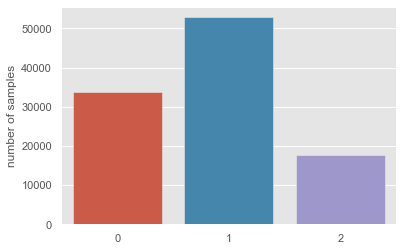

In [6]:
x = df.target.value_counts()
sns.barplot(x.index, x)
plt.gca().set_ylabel('number of samples')

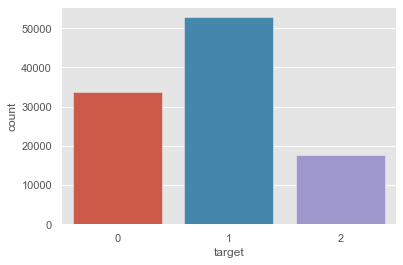

In [7]:
sns.countplot(x='target', data=df)

In [8]:
def create_corpus(target):
    corpus = []
    
    for x in df[df['target']==target]['text'].str.split():
        for i in x:
            corpus.append(i)
    return corpus

def get_frequent_words(corpus, top_n=10):
    dic = defaultdict(int)
    for word in corpus:
        if word in stop:
            dic[word] += 1

    top = sorted(dic.items(), key=lambda x: x[1], reverse=True)[:top_n]

    return zip(*top)

Text(0.5, 1.0, 'Raise')

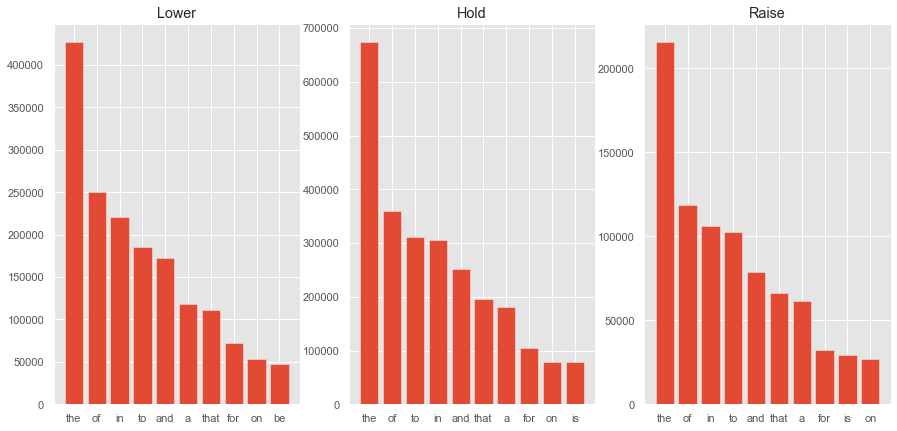

In [9]:
# Most frequent words
corpus_lower = create_corpus(0)
corpus_hold = create_corpus(1)
corpus_raise = create_corpus(2)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15,7))
x, y = get_frequent_words(corpus_lower)
ax1.bar(x, y)
ax1.set_title('Lower')
x, y = get_frequent_words(corpus_hold)
ax2.bar(x, y)
ax2.set_title('Hold')
x, y = get_frequent_words(corpus_raise)
ax3.bar(x, y)
ax3.set_title('Raise')

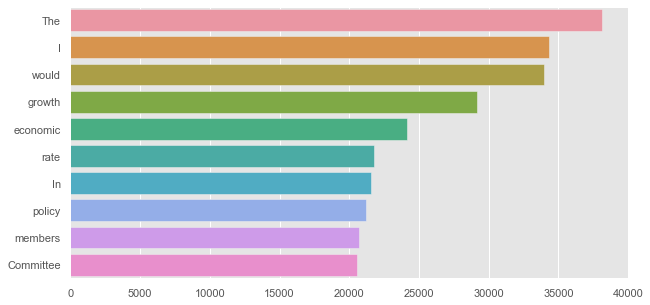

In [10]:
# Check most frequent words which are not in stopwords
counter = Counter(corpus_lower)
most = counter.most_common()
x, y = [], []
for word, count in most[:40]:
    if word not in stop:
        x.append(word)
        y.append(count)

plt.figure(figsize=(10,5))
sns.barplot(x=y, y=x)

Text(0.5, 1.0, 'Script')

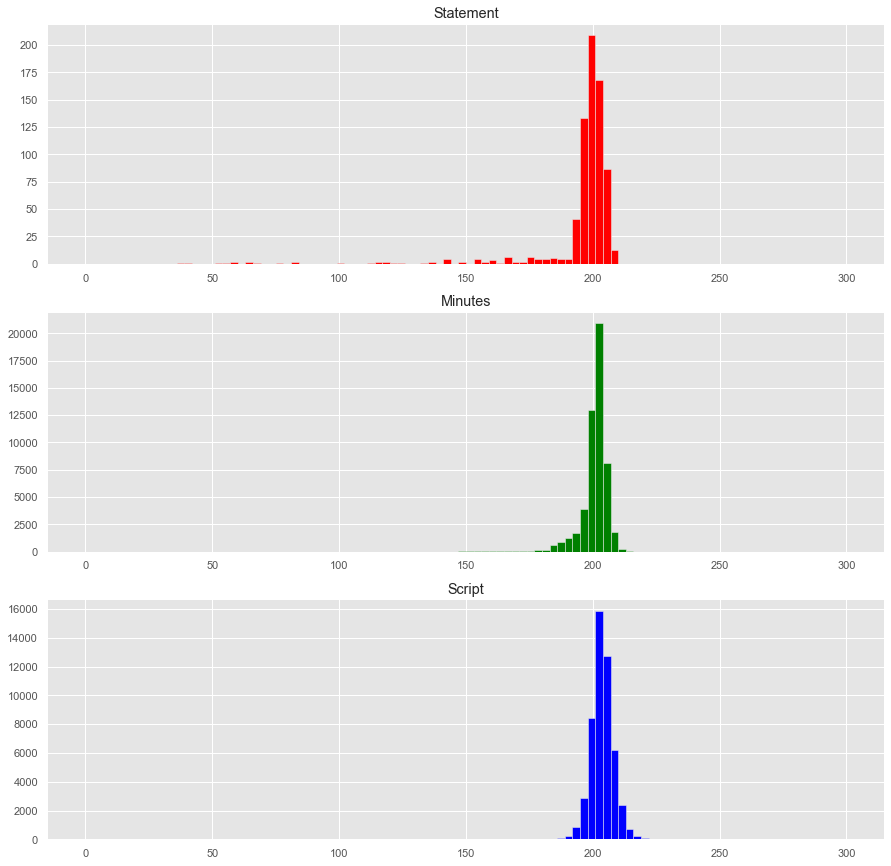

In [11]:
# fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(15,15))
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(15,15))
contents_len = df[df['type'] == 'statement']['word_count']
ax1.hist(contents_len, color='red', bins=100, range=(0,300))
ax1.set_title('Statement')
contents_len = df[df['type'] == 'minutes']['word_count']
ax2.hist(contents_len, color='green', bins=100, range=(0,300))
ax2.set_title('Minutes')
contents_len = df[df['type'] =='script']['word_count']
ax3.hist(contents_len, color='blue', bins=100, range=(0,300))
ax3.set_title('Script')
# contents_len = df[df['type'] =='speech']['word_count']
# ax4.hist(contents_len, color='brown', bins=100, range=(0,20000))
# ax4.set_title('Speech')


In [12]:
# Let's use statements only first
train_df = df[df['type']=='statement']
train_df.head()

,text,rate,stmt_date,target,type,target_lower,target_hold,target_raise,word_count
0,Chairman Alan Greenspan announced today that t...,3.25,1994-02-04,2,statement,0,0,1,99
1,"In taking the discount action, the Board appro...",3.50,1994-03-22,2,statement,0,0,1,57
2,Chairman Alan Greenspan announced today that t...,3.75,1994-04-18,2,statement,0,0,1,37
3,"In a related move, the Federal Open Market Com...",4.25,1994-05-17,2,statement,0,0,1,121
4,"In taking the discount rate action, the Board ...",4.75,1994-08-16,2,statement,0,0,1,51


## Tokenize

### Input class

In [13]:
class InputFeature(object):
    """ A single training/test data class """
    def __init__(self, id, input_ids, masks, segments, label=None):
        self.id = id
        self.features = {
            'input_ids': input_ids,
            'input_mask': masks,
            'segment_ids': segments
        }
        self.label = label

### BERT Encoder

In [14]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

In [15]:
def bert_encoder(text, max_len=512):
    """ Return embedded text vector as a list in max_len with a mask list"""
    text_token = tokenizer.tokenize(text)
    text_token = text_token[:max_len-2]
    text_token = ["[CLS]"] + text_token + ["[SEP]"]
    text_ids = tokenizer.convert_tokens_to_ids(text_token)
    text_ids += [0] * (max_len - len(text_token))
    pad_masks = [1] * len(text_token) + [0] * (max_len - len(text_token))
    segment_ids = [0] * len(text_token) + [0] * (max_len - len(text_token))
    
    return text_ids, pad_masks, segment_ids

### Tokenize input texts

In [16]:
train_set = []
max_seq_length = 256

for index, row in train_df.iterrows():
    input_ids, masks, segments = bert_encoder(row.text, max_seq_length)
    train_set.append(InputFeature(row.index, input_ids, masks, segments, row.target))


train_labels = train_df['target'].astype(int).values

# numpy array to split train and valid within Fold later
train_valid_input_ids = np.array([data.features['input_ids'] for data in train_set])
train_valid_input_masks = np.array([data.features['input_mask'] for data in train_set])
train_valid_segment_ids =np.array([data.features['segment_ids'] for data in train_set])
train_valid_labels = np.array([data.label for data in train_set])

### Create a Model

In [17]:
# Complex Model by adding 5 horizontal dropout layers (multi-sample dropout)
class MultiSampleDropoutModel(nn.Module):
    def __init__(self, hidden_size=768, num_class=3):
        super(MultiSampleDropoutModel, self).__init__()

        self.bert = BertModel.from_pretrained('bert-base-uncased',  
                                        output_hidden_states=True,
                                        output_attentions=True)
        for param in self.bert.parameters():
            param.requires_grad = True
        self.weights = nn.Parameter(torch.rand(13, 1))
        self.dropouts = nn.ModuleList([
            nn.Dropout(0.5) for _ in range(5)
        ])
        self.fc = nn.Linear(hidden_size, num_class)

    def forward(self, input_ids, input_mask, segment_ids):
        all_hidden_states, all_attentions = self.bert(input_ids, token_type_ids=segment_ids,
                                                                attention_mask=input_mask)[-2:]
        batch_size = input_ids.shape[0]
        ht_cls = torch.cat(all_hidden_states)[:, :1, :].view(13, batch_size, 1, 768)
        atten = torch.sum(ht_cls * self.weights.view(13, 1, 1, 1), dim=[1, 3])
        atten = F.softmax(atten.view(-1), dim=0)
        feature = torch.sum(ht_cls * atten.view(13, 1, 1, 1), dim=[0, 2])
        for i, dropout in enumerate(self.dropouts):
            if i == 0:
                h = self.fc(dropout(feature))
            else:
                h += self.fc(dropout(feature))
        h = h / len(self.dropouts)
        return h  

In [18]:
# Hyperparameters
learning_rate = 1e-5  
num_epochs = 3  
batch_size = 8  
patience = 2  
file_name = 'model'

In [19]:
# Define metrics
def metric(y_true, y_pred):
    acc = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average='macro')
    return acc, f1

In [20]:
skf = StratifiedKFold(n_splits=7, shuffle=True, random_state=42)
oof_train = np.zeros((len(train_df), 2), dtype=np.float32)

## Train

In [21]:
for fold, (train_indices, valid_indices) in enumerate(skf.split(train_valid_labels, train_valid_labels)):
    
    # Number of folds to iterrate
    if fold == 2:
        break

    logger.info('================     fold {}        ==============='.format(fold))
    
    # Train Data in Tensor
    train_input_ids = torch.tensor(train_valid_input_ids[train_indices], dtype=torch.long)
    train_input_mask = torch.tensor(train_valid_input_masks[train_indices], dtype=torch.long)
    train_segment_ids = torch.tensor(train_valid_segment_ids[train_indices], dtype=torch.long)
    train_label = torch.tensor(train_valid_labels[train_indices], dtype=torch.long)
    
    # Validation Data in Tensor
    valid_input_ids = torch.tensor(train_valid_input_ids[valid_indices], dtype=torch.long)
    valid_input_mask = torch.tensor(train_valid_input_masks[valid_indices], dtype=torch.long)
    valid_segment_ids = torch.tensor(train_valid_segment_ids[valid_indices], dtype=torch.long)
    valid_label = torch.tensor(train_valid_labels[valid_indices], dtype=torch.long)

    # Load data into TensorDataset
    train = torch.utils.data.TensorDataset(train_input_ids, train_input_mask, train_segment_ids, train_label)
    valid = torch.utils.data.TensorDataset(valid_input_ids, valid_input_mask, valid_segment_ids, valid_label)
    
    # Use DataLoader to load data from Dataset in batches
    train_loader = torch.utils.data.DataLoader(train, batch_size=batch_size, shuffle=True)
    valid_loader = torch.utils.data.DataLoader(valid, batch_size=batch_size, shuffle=False)

    # Set Model
    model = BertForSequenceClassification.from_pretrained(
        "bert-base_uncased",
        num_labels = 3,
        output_attentions = False,
        output_hidden_states = False,
    )
    
    # Move model to GUP/CPU device
    device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
    model = model.to(device)
    
    # Loss Function - use Cross Entropy as binary classification
    loss_fn = torch.nn.CrossEntropyLoss()

    # Optimizer - Adam with parameter groups
    param_optimizer = list(model.named_parameters())
    no_decay = ['bias', 'LayerNorm.bias', 'LayerNorm.weight']
    optimizer_grouped_parameters = [
        {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
        {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}]

    optimizer = AdamW(optimizer_grouped_parameters, lr=learning_rate, eps=1e-6)
    
    # Set Train Mode
    model.train()

    # Initialize
    best_f1 = 0.
    valid_best = np.zeros((valid_label.size(0), 2))
    early_stop = 0
    
    for epoch in range(num_epochs):
        train_loss = 0.
        for i, batch in tqdm(enumerate(train_loader)):
            # Move batch data to device
            batch = tuple(t.to(device) for t in batch)
            # Bert input features and labels from batch
            x_ids, x_mask, x_sids, y_truth = batch
            
            # Feedforward prediction
            y_pred = model(x_ids, x_mask, x_sids)
            # Calculate Loss
            loss = loss_fn(y_pred, y_truth)
            # Reset gradient
            optimizer.zero_grad()
            # Backward Propagation
            loss.backward()
            # Update Weights
            optimizer.step()
            # Training Loss
            train_loss += loss.item() / len(train_loader)
            
            #logger.debug('train batch: %d, train_loss: %8f\n' % (i, train_loss))
    
        # Move to Evaluation Mode
        model.eval()
        
        # Initialize
        val_loss = 0.
        valid_preds_fold = np.zeros((valid_label.size(0), 2))
        
        with torch.no_grad():
            for i, batch in tqdm(enumerate(valid_loader)):
                batch = tuple(t.to(device) for t in batch)
                x_ids, x_mask, x_sids, y_truth = batch
                y_pred = model(x_ids, x_mask, x_sids).detach()
                val_loss += loss_fn(y_pred, y_truth).item() / len(valid_loader)
                valid_preds_fold[i * batch_size:(i + 1) * batch_size] = F.softmax(y_pred, dim=1).cpu().numpy()
                
                # print('validation batch: {}, val_loss: {}, valid_preds_fold: {}'.format(i, val_loss, valid_preds_fold[i * batch_size:(i + 1) * batch_size]))
    
        # Calculate metrics
        acc, f1 = metric(train_valid_labels[valid_indices], np.argmax(valid_preds_fold, axis=1))
        
        # If improving, save the model. If not, count up for early stopping
        if best_f1 < f1:
            early_stop = 0
            best_f1 = f1
            valid_best = valid_preds_fold
            torch.save(model.state_dict(), 'model_fold_{}.bin'.format(fold))
        else:
            early_stop += 1
            

        logger.info(
            'epoch: %d, train loss: %.8f, valid loss: %.8f, acc: %.8f, f1: %.8f, best_f1: %.8f\n' %
            (epoch, train_loss, val_loss, acc, f1, best_f1))
        
        if device == 'cuda:0':
            torch.cuda.empty_cache()  
        
        # Early stop if it reaches patience number
        if early_stop >= patience:
            break
            
        model.train()

    # Once all epochs are done, take the best model of the fold
    valid_preds_fold = np.zeros((valid_label.size(0), 2))
    
    # Load the best model
    model.load_state_dict(torch.load('model_fold_{}.bin'.format(fold)))
    # Set Evaluation Mode
    model.eval()
    
    # Prediction on the validation set
    with torch.no_grad():
        for i, batch in tqdm(enumerate(valid_loader)):
            batch = tuple(t.cuda() for t in batch)
            x_ids, x_mask, x_sids, y_truth = batch
            y_pred = model(x_ids, x_mask, x_sids).detach()
            valid_preds_fold[i * batch_size:(i + 1) * batch_size] = F.softmax(y_pred, dim=1).cpu().numpy()


    # Check the metrics for the validation set
    valid_best = valid_preds_fold
    oof_train[valid_indices] = valid_best
    acc, f1 = metric(train_valid_labels[valid_indices], np.argmax(valid_best, axis=1))
    logger.info('epoch: best, acc: %.8f, f1: %.8f, best_f1: %.8f\n' % (acc, f1, best_f1))

[2020-02-18 16:47:05,213][INFO] ## ================     fold 0        ===============


OSError: Model name 'bert-base_uncased' was not found in model name list. We assumed 'https://s3.amazonaws.com/models.huggingface.co/bert/bert-base_uncased/config.json' was a path, a model identifier, or url to a configuration file named config.json or a directory containing such a file but couldn't find any such file at this path or url.

In [ ]:
logger.info(f1_score(labels, np.argmax(oof_train, axis=1)))
train_df['pred_target'] = np.argmax(oof_train, axis=1)

In [ ]:
train_df.head()